In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from magicctapipe.io import get_dl2_mean
import scipy.optimize

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
school_directory='/fefs/aswg/workspace/2023_joint_analysis_school'

gammapath=school_directory+'/MCs/input/dl2_gamma_zd_*_az_*_LST-1_MAGIC_run*.h5'
gammafiles=glob.glob(gammapath)
weight_type="intensity"

In [3]:
# read spectral index from the first file (assuming that all the files have the same !!)
index = pd.read_hdf(gammafiles[0], 'simulation/config')['spectral_index'][0]
print("simulations with index: ", index)

simulations with index:  -2.0


## load the DL2 data and calculate the event-wise RF averages

In [4]:
dfs= ((f,pd.read_hdf(f, 'events/parameters')) for f in gammafiles)
dfs_mean=[]
for (f,df) in dfs:
    df.set_index(['obs_id', 'event_id', 'tel_id'], inplace=True)
    df.sort_index(inplace=True)
    
    # keep only events that survived MAGIC hardware trigger
    df.query('(magic_stereo == True)', inplace=True)
    dfs_mean.append(get_dl2_mean(df, weight_type=weight_type))
    print(f)
    
df_mc = pd.concat(dfs_mean, ignore_index=True) 

/fefs/aswg/workspace/2023_joint_analysis_school/MCs/input/dl2_gamma_zd_10.0deg_az_102.2deg_LST-1_MAGIC_run10102_to_20002.h5
/fefs/aswg/workspace/2023_joint_analysis_school/MCs/input/dl2_gamma_zd_10.0deg_az_102.2deg_LST-1_MAGIC_run20102_to_30002.h5
/fefs/aswg/workspace/2023_joint_analysis_school/MCs/input/dl2_gamma_zd_10.0deg_az_102.2deg_LST-1_MAGIC_run102_to_10002.h5


## function to fit a gaussian to a log energy distribution and get the peak position

In [5]:
def fit_gaus(hist, emin=np.NaN, emax=np.NaN):
    gaus = lambda x, mean, std, norm : norm * np.exp(-(x-mean)**2 / (2*std**2))
    x=0.5*(hist[1][1:]+hist[1][:-1])
    # apply energy cuts
    cut=~((10**x<emin) | (10**x > emax))
    x=x[cut]
    y=hist[0][cut]
    # starting parameters: using highest bin
    start=(x[y.argmax()], 0.3, y.max())
    pars, _ = scipy.optimize.curve_fit(gaus, x, y, p0=start)
    print("Energy threshold = ",10**pars[0], " GeV")
    plt.plot(x, gaus(x, *pars), label="fit")

## make the energy histogram
we plot it in logarithmic binning, which means that we not only need to correct for the spectral index difference between HEGRA Crab-like (-2.6) and simulated (-2), but also divide additionally by the energy 

Energy threshold =  56.98537031037567  GeV
Energy threshold =  65.07547421068956  GeV


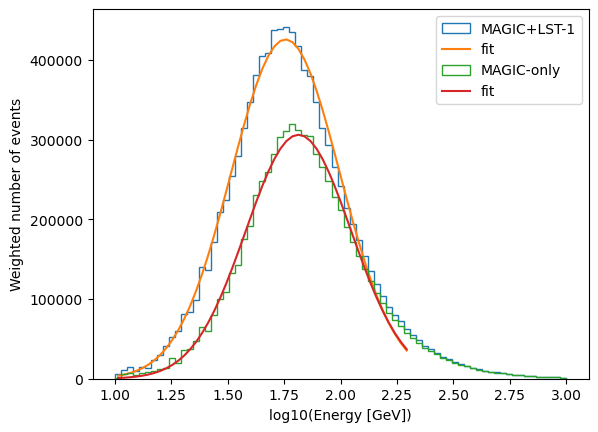

In [6]:
weights = df_mc['true_energy']**(-2.6 - index - 1 )

# MAGIC + LST-1 - all combinations
h1=plt.hist(np.log10(df_mc['true_energy']*1.e3), weights=weights, bins=75, range=(1,3), histtype='step', label='MAGIC+LST-1')
fit_gaus(h1, emin=10, emax=200)

# MAGIC-only, only M1+M2, or LST1+M1+M2
cut=(df_mc['combo_type']==0) | (df_mc['combo_type']==3)
h2=plt.hist(np.log10(df_mc['true_energy'][cut]*1.e3), weights=weights[cut], bins=75, range=(1,3), histtype='step', label='MAGIC-only')

fit_gaus(h2, emin=10, emax=200)

plt.xlabel('log10(Energy [GeV])')
plt.ylabel('Weighted number of events')

plt.legend()
plt.show()